In [ ]:
!pip install datasets
!pip install evaluate
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -U bitsandbytes
# !pip install -q git+https://github.com/gmihaila/ml_things.git
!pip install trl
!pip install arabert
!pip install wandb
# !pip install shap
!pip install captum

In [2]:
from datasets import Dataset, load_dataset
import evaluate
from transformers import (GPT2Tokenizer,
                          AutoTokenizer,
                          GPT2LMHeadModel,
                          AutoModelForSequenceClassification,
                          AutoModelForCausalLM,
                          TrainingArguments,
                          Trainer,
                          BitsAndBytesConfig,
                          pipeline,
                          logging)
from transformers import logging as hf_logging

import torch.nn.functional as F

from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

import bitsandbytes as bnb

import pandas as pd
import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm import tqdm

# from trl import SFTTrainer
# from trl import setup_chat_format

# import bitsandbytes
import os
import string
import json
import re
import time
import random
import warnings
import logging
from collections import defaultdict
from typing import List
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             classification_report,
                             confusion_matrix,
                             auc)

from huggingface_hub import login
from arabert.preprocess import ArabertPreprocessor

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, rgb2hex
from matplotlib.ticker import PercentFormatter 
from IPython.display import HTML
from pylab import rcParams
import seaborn as sns

print(f"pytorch version {torch.__version__}")

pytorch version 2.5.1+cu121


In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  # CPU vars
    torch.manual_seed(seed_value)  # CPU vars
    random.seed(seed_value)  # Python random seed
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # GPU vars
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def format_duration(total_time):
    time_delta = timedelta(seconds=total_time)
    hours, remainder = divmod(time_delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{} hours, {} minutes, {} seconds".format(hours, minutes, seconds)

In [4]:
 # Set the seed
SEED = 42
random_seed(SEED, torch.cuda.is_available())

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# Dataset

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib.ticker import PercentFormatter

class HardDataset:
    def __init__(self, data_path, seed=42, use_subset=False):
        """
        Initializes the dataset class.
        
        Args:
            data_path (str): The path to the dataset file.
            seed (int): Random seed for reproducibility.
            use_subset (bool): Whether to use a subset of the dataset or the entire dataset.
        """
        self.data_path = data_path
        self.seed = seed
        self.use_subset = use_subset
        self.df = None

    def load_data(self):
        """
        Load the data from a TSV file and retain only the 'rating' and 'review' columns.
        Also, transform the 'rating' to a binary label (positive/negative).
        
        Returns:
            pd.DataFrame: The loaded and preprocessed DataFrame.
        """
        # Load the dataset
        self.df = pd.read_csv(self.data_path, delimiter='\t')

        # Keep only 'rating' and 'review' columns
        self.df = self.df[['rating', 'review']]

        # Code rating: positive (1) if rating > 3, negative (0) if rating < 3
        self.df['rating'] = self.df['rating'].apply(lambda x: 0 if x < 3 else 1)

        # Rename columns for consistency with standard text classification format
        self.df.columns = ['label', 'text']
        print(f"Initial dataset length: {len(self.df)}")

        # Apply the subset logic if needed
        if self.use_subset:
            self.df = self.filter_and_sample_data(self.df)

        return self.df

    def filter_and_sample_data(self, df):
        """
        Filter and sample the dataset based on word count and class balance.
        
        Args:
            df (pd.DataFrame): The full dataset before filtering.
        
        Returns:
            pd.DataFrame: The filtered and balanced DataFrame.
        """
        print("\nFiltering dataset based on word count and label balance...")
        # Remove instances with word count greater than 100
        df["word_count"] = df['text'].apply(lambda x: len(x.split()))
        df = df[df['word_count'] < 100]
        print(f"Dataset length after word count filter: {len(df)}")

        # Limit samples per label to max_samples
        max_samples = 7000
        df_sampled = df.groupby("label")[["text", "label"]].apply(
            lambda x: x.sample(n=min(len(x), max_samples))
        )
        df_sampled = df_sampled.reset_index(drop=True)

        print(f"Dataset length after class balancing: {len(df_sampled)}")
        return df_sampled

    def analyze_data(self):
        """
        Perform exploratory data analysis on the dataset.
        This includes visualizing label distribution and word count distribution.
        """
        if self.df is None:
            raise ValueError("Data not loaded. Please call 'load_data()' first.")

        # Show label distribution
        label_counts = self.df['label'].value_counts()
        print("\nLabel Distribution:")
        print(label_counts)

        # Visualize label distribution
        plt.figure(figsize=(6, 4))
        sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
        plt.title("Label Distribution")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.show()

    def split_data(self):
        """
        Split the dataset into train, validation, and test sets.
        
        Returns:
            pd.DataFrame: Train, validation, and test datasets as separate DataFrames.
        """
        # Split the data into train, validation, and test sets
        train_df, temp_df = train_test_split(self.df, test_size=0.2, random_state=self.seed)
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=self.seed)

        print(f"Train shape: {train_df.shape}")
        print(f"Validation shape: {val_df.shape}")
        print(f"Test shape: {test_df.shape}")

        return train_df, val_df, test_df

Initial dataset length: 105698

Filtering dataset based on word count and label balance...
Dataset length after word count filter: 103804
Dataset length after class balancing: 14000

Label Distribution:
label
0    7000
1    7000
Name: count, dtype: int64


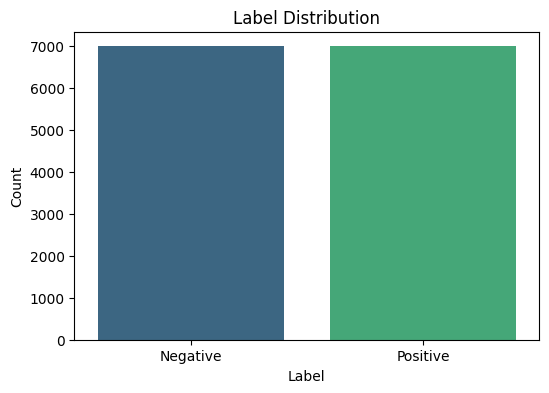

Train shape: (11200, 2)
Validation shape: (1400, 2)
Test shape: (1400, 2)


In [38]:
DATASET_PATH = "data/arabic-sa-hard-dataset/balanced-reviews-utf8.tsv"
# Initialize the dataset class
# To use the whole dataset set use_subset to False
dataset = HardDataset(data_path=DATASET_PATH, seed=42, use_subset=True)

# Load data
df = dataset.load_data()

# Optionally analyze the data
dataset.analyze_data()

# Split data into train, validation, and test sets
train_df, val_df, test_df = dataset.split_data()

In [39]:
def create_prompt(text: str, label: str = None):
    # Formulate the text with a specific instruction for classification
    prompt = """
You will be given an Arabic hotel review. Your task is to classify it as one of the labels in the list: positive, negative. Output the label only, and nothing else.
<text>
{text}
</text>
Answer: {label}
""".strip()
    return prompt.format(text=text, label=label)

# Mapping dictionary
def create_dataset(df):
    """
    Create a dataset for training, validation, or testing.
    If is_test=True, exclude the label from the prompt.
    If not, map the raw labels (0, 1) to strings ('negative', 'positive').
    """
    label_map = {1: "positive", 0: "negative"}
    rows = []
    for _, row in tqdm(df.iterrows()):
        label = label_map[row.label]  # Map raw labels to strings
        rows.append(
            {
                "input": create_prompt(row.text, label),
                "output": label 
            }
        )
    return rows

In [40]:
# df_pandas_test['label'] = df_pandas_test['label'].replace({1: 'positive', 0: 'negative'})
train_rows = create_dataset(train_df)
Path("hard_train_data.json").write_text(json.dumps(train_rows))
print(train_rows[0]["input"], "\n")

dev_rows = create_dataset(val_df)
Path("hard_dev_data.json").write_text(json.dumps(dev_rows))
print(dev_rows[1]["input"], "\n")

11200it [00:00, 14524.64it/s]


You will be given an Arabic hotel review. Your task is to classify it as one of the labels in the list: positive, negative. Output the label only, and nothing else.
<text>
“فندق رائع”. تعاون الموظفين كان رائعا كان لي بعض التعليقات على مستوى الاثاث ولكن ادارة الفندق اسرعت بتغير كل ما يلزم في الغرفه مع الكرم الاضافي بلا مقابل المدير متعاون الى ابعد درجه. بعض اثاث الغرفه يحتاج الى تغير ككراسي الضيافه المصاعد لم تكن كلها تعمل مما تسبب في الزحام والتكدس الزائد عند كل صلاه
</text>
Answer: positive 



1400it [00:00, 14942.42it/s]


You will be given an Arabic hotel review. Your task is to classify it as one of the labels in the list: positive, negative. Output the label only, and nothing else.
<text>
ضعيف جداً. . لا يستحق 5 نجوم
</text>
Answer: negative 



In [41]:
def create_prompt(text: str, label: str = None):
    # Formulate the text with a specific instruction for classification
    prompt = """
You will be given an Arabic hotel review. Your task is to classify it as one of the labels in the list: positive, negative. Output the label only, and nothing else.
<text>
{text}
</text>
Answer:
""".strip()
    return prompt.format(text=text, label=label)
    
test_rows = create_dataset(test_df)
Path("hard_test_data.json").write_text(json.dumps(test_rows))

print(test_rows[0]["input"], "\n")

1400it [00:00, 10521.12it/s]

You will be given an Arabic hotel review. Your task is to classify it as one of the labels in the list: positive, negative. Output the label only, and nothing else.
<text>
“الموقع ممتاز اكن الغرفة صغيره جدا”. موقع مميز قريب من الحرم دقائق معدودة والفندق نظيف والاثاث يعتبر جديد. غرفه صغيره جدا الباب لم يفتح بالبطاقه الذكيه كل مره ندخل فيها للغرفة لا يفتح الباب لمدة يومين ونتظطر للانتظار والنزول للاستقبال ولا يفتح الا بالمستر كي وخدمة حامل الحقائب تأخر علينا ونزلت وانا احمل جميع حقائبي وغير ذلك لا يوجد ملاحظات
</text>
Answer: 



# Model Loading and Fine-tuning

In [43]:
# --- Configuration Functions ---
def setup_tokenizer(model_id: str):
    """Sets up the tokenizer for the model."""
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    print("Vocabulary size:", len(tokenizer))
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    return tokenizer

def setup_quantization():
    """Sets up the quantization configuration."""
    nf4_config = BitsAndBytesConfig(
        load_in_4bit=True, # Enables 4-bit quantization of the base model to reduce memory usage.
        bnb_4bit_quant_type="nf4", #  The quantization type ("nf4" is a common choice)
        bnb_4bit_use_double_quant=True, # Enables nested quantization (double quantization) for further memory reduction.
        bnb_4bit_compute_dtype=torch.bfloat16 # Specifies the data type for computations during training (float16 in this case).
    )
    return nf4_config

def setup_model(model_id: str, nf4_config):
    """Loads the model with quantization and configuration."""
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=nf4_config
    )
    model.config.use_cache = False
    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)
    return model

def setup_lora(modules):
    """Sets up the LoRA configuration."""
    lora_config = LoraConfig(
        r=64,  # 8
        lora_alpha=16, 
        target_modules=modules, # check target_modules for any model (see function target_modules)
        lora_dropout=0.1, # 0.05 increase (e.g., 0.2-0.3) for small datasets or noisy data.
        bias="none",
        task_type="CAUSAL_LM"
    )
    return lora_config

def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params} || Total params: {all_param} || Trainable%: {100 * trainable_params / all_param:.2f}")

# --- Main Training Function ---

def train_model(model, task: str, modules, train_dataset, val_dataset):
    """Handles the entire training process."""
    os.environ["WANDB_PROJECT"] = f"model_name{task}"
    os.environ["WANDB_LOG_MODEL"] = "checkpoint"
    # Apply LoRA
    model.enable_input_require_grads()
    model = get_peft_model(model, lora_config)
    print_trainable_parameters(model)
    model = model.to(device)
    model.hf_device_map

    # Create Trainer instance
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        args = SFTConfig(
            dataset_text_field ="input",
            # max_seq_length=512,
            output_dir=f"model_name{task}",
            eval_strategy="epoch",
            save_strategy="epoch", 
            # eval_steps = 0.2
            learning_rate=2e-4, # 2e-5 learning rate, based on QLoRA paper 2e-4
            per_device_train_batch_size=4, #
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=1,            # number of steps before performing a backward/update pass
            # gradient_checkpointing=True,              # use gradient checkpointing to save memory
            optim="paged_adamw_32bit",
            fp16=True,
            bf16=False,
            num_train_epochs=3, 
            weight_decay=0.001, # Lower (e.g., 0.001) if underfitting or noisy datasets.
            max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
            max_steps=-1,
            # group_by_length=False,
            lr_scheduler_type="cosine",               # use cosine learning rate scheduler
            warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
            logging_dir="./logs",
            logging_steps=50, # try 1
            report_to="wandb",
            push_to_hub=True,
            packing=False,
        ),
        peft_config=lora_config,
        # dataset_kwargs={
        #     "add_special_tokens": False,
        #     "append_concat_token": False
        # }
    )

    # Train the model
    start_time = time.time()
    trainer.train()
    end_time = time.time()

    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} seconds")

In [ ]:
# Building the model
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
if __name__ == "__main__":
    login(token="your_hf") # write token
    !wandb login your_wandb_token
    model_id = "meta-llama/Llama-3.2-3B-Instruct"
    task = "ASA" # Arabic Sentiment Analysis

    train_dataset = Dataset.from_list(train_rows)
    dev_dataset = Dataset.from_list(dev_rows)

    tokenizer = setup_tokenizer(model_id)
    nf4_config = setup_quantization()
    model = setup_model(model_id, nf4_config)
    model = model.to(device)
    modules = find_all_linear_names(model)
    lora_config = setup_lora(modules)
    # train_model(p_model, task, formatting_prompts_func_sst2, modules)
    train_model(model, task, modules, train_dataset, dev_dataset)

# Inference

In [ ]:
# Load finetuned model from huggingface
login(token="your_hf_token") 
model_id = ""
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
nf4_config = setup_quantization()
model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=nf4_config
        ).to(device)
model.config.use_cache = False

In [ ]:
# One instance
%%time
tokenizer.pad_token = tokenizer.eos_token
inp_test = test_rows[0]["input"]
messages = [{"role": "user", "content": inp_test}]
content = messages[0]["content"]
inputs = tokenizer(content, return_tensors="pt", padding=True, truncation=True).to(device)
outputs = model.generate(**inputs, max_new_tokens=1, temperature=0.000001, pad_token_id=tokenizer.eos_token_id)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)
parts = [part.strip() for part in generated_text.split("Answer:") if part.strip()]


regex = r"^\W+|\W+$"
prediction = re.sub(regex, "", parts[-1])
print(prediction)

In [ ]:
%%time
tokenizer.pad_token = tokenizer.eos_token
predictions = []
true_values = []
for row in tqdm(test_rows):
    messages = [{"role": "user", "content": row["input"]}]
    content = messages[0]["content"]
    inputs = tokenizer(content, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=1, temperature=0.000001, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    parts = [part.strip() for part in generated_text.split("Answer:") if part.strip()]
    predictions.append(parts[-1])
    true_values.append(row["output"])

regex = r"^\W+|\W+$"
predictions = [re.sub(regex, "", p) for p in predictions]
len(true_values), len(predictions)
pd.Series(predictions).value_counts()

In [ ]:
# if the model generated classes that doesn't exist
class_names = ['positive', 'negative']
eval_df = pd.DataFrame().from_dict({"label":true_values, "prediction":predictions})
len(eval_df[~eval_df.prediction.isin(class_names)]) # check ...
eval_df = eval_df[eval_df.prediction.isin(class_names)] # remove if len > 0

In [ ]:
print(accuracy_score(true_values, predictions))
print(classification_report(eval_df.label, eval_df.prediction))

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(eval_df.label, eval_df.prediction, labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()